# Exploratory Data Analysis

## Sections
* [First look at the data](#first-look)
* [Preprocessing](#preprocessing)
* [Class distributions](#class-distributions)
* [Correlations](#correlations)
* [Merging](#merging)
* [Data type optimization](#data-type-optimization)
* [Scatter plots](#scatter-plots)
* [Number of comments](#number-of-comments)
* [Feature engineering](#feature-engineering)
* [Simple first linear prediction model](#prediction-with-linear)
* [Summary](#summary)

In [2]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_08.csv')
df_com = pd.read_csv('comments_2017_08.csv').sample(30000) # crop because battery life, skews data
# Make float better readable
pd.options.display.float_format = '{:.0f}'.format

<a id="first-look"></a>

### First Look

In [3]:
df_art.head(3)

,tId,article_id,updated,num_comments,link,header,sub,text
0,18602624,18602624,1502366470,0,/schweiz/ostschweiz/story/-Er-rannte-ihm-mit-d...,«Er rannte ihm mit der Mistgabel hinterher»,Ein ehemaliger Mitarbeiter erinnert sich an se...,Der heute 22-jährige Pferdepfleger Jonas M. (N...
1,23276166,23276166,1502975307,0,/schweiz/basel/story/23276166,Unter Drogen und Alkohol Zugbegleiter verprügelt,von Adrian Jäggi - Unter dem Einfluss von Koka...,Der Angeklagte erinnerte sich am Donnerstag vo...
2,16318631,16318631,1502461204,40,/community/dossier/geldratgeber/story/16318631,Muss ich bei Vertragsbruch zahlen?,Marianna (27) schuldet ihrem Arbeitgeber eine ...,Lieber Phil Geld Ich habe eine neue Arbeitsste...


In [4]:
df_com.head(3)

,tId,cId,mob,vup,vdo,tit,aut,time,con
11149,11387784,987_987,1,19,3,Arbeitslose Zukunft,SinnLos,am 11.08.2017 18:53,Alles muss immer günstiger werden. Warten wir...
147025,31983509,93_131,1,10,5,@Lexie,wirklich,am 19.07.2017 18:55,Keine Antwort. Ihr Argument ist kein Argument.
31827,12417164,255_287,0,19,0,"In massen geht alles, nicht in Massen!",Best,am 16.08.2017 12:28,Zauber Wort liegt bei dosiert!


In [5]:
print(df_art.shape)
print(df_com.shape)

(2203, 8)
(30000, 9)


In [6]:
print(df_art.dtypes)
print(' ')
print(df_com.dtypes)

tId               int64
article_id        int64
updated         float64
num_comments      int64
link             object
header           object
sub              object
text             object
dtype: object
 
tId      int64
cId     object
mob      int64
vup      int64
vdo      int64
tit     object
aut     object
time    object
con     object
dtype: object


In [7]:
df_art.describe()

# Summary:
# No missing attributes since count is the same everywhere
# No negative values, chi^2 etc. can be used

,tId,article_id,updated,num_comments
count,2203,2203,2203,2203
mean,21061233,21052444,1502709137,81
std,6368942,6371428,387947,146
min,10003016,10003016,1502017728,0
25%,15621780,15606790,1502362126,0
50%,21135729,21128545,1502749938,29
75%,26602800,26602800,1503047695,93
max,31996579,31996579,1503257380,1838


In [8]:
df_com.describe()

# Summary:
# No missing attributes 
# No negative values

,tId,mob,vup,vdo
count,30000,30000,30000,30000
mean,20944251,1,45,17
std,6350757,0,113,36
min,10003016,0,0,0
25%,15594422,0,7,2
50%,20650393,1,20,6
75%,26586313,1,45,16
max,31996579,1,3772,1072


In [9]:
print(df_art.skew())
# Makes only sense on 'num_comments'

tId             0
article_id      0
updated        -0
num_comments    4
dtype: float64


In [10]:
print(df_com.skew())
# Skew is not high enough that it has to be corrected

tId    0
cId    3
mob   -1
vup   12
vdo    8
dtype: float64


<a id='preprocessing'></a>

### Preprocessing
To make further analysis possible, we'll add some columns.

In [11]:
from datetime import datetime
#from sklearn.preprocessing import LabelEncoder

# Articles

df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()
df_com['aut'] = df_com['aut'].astype('category') # saves memory

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category).astype('category')
#lenc = LabelEncoder()
#df_art['cat_enc'] = lenc.fit_transform(df_art['cat'])
df_art['header_len'] = df_art['header'].apply(lambda x: len(x))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))


# Comments

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return (get_dt_obj(time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

#def get_weekday_hour(time):
#    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['time_since_epoch'] = df_com['time'].apply(time_since_epoch)
df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
#df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['activity'] = df_com['vup'] + df_com['vdo']

<a id='class-distributions'></a>

### Class Distributions

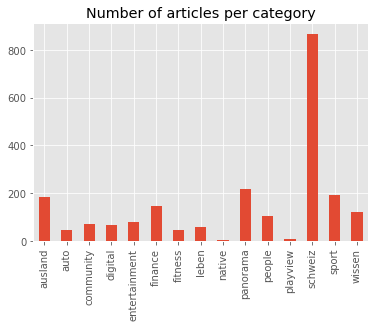

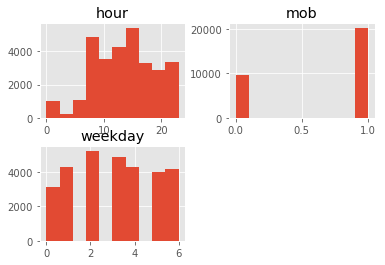

In [12]:
# Articles
df_art.groupby(['cat']).size().plot.bar(
    title='Number of articles per category')
plt.xlabel('')
plt.show()

# Comments
column = ['hour', 'weekday', 'mob']
a = df_com.hist(column=column)

<a id='correlations'></a>

### Correlations
Let's find relations between some of the attributes. Correlation requires continuous data.

In [13]:
# Only for these columns
# Removed 'vup', 'vdo' because of performance
cols = ['score', 'activity', 'hour', 'weekday', 'weekday_fl', 'mob', 'is_answer', 'con_len']

# Change back how float is displayed
pd.options.display.float_format = '{:.2f}'.format

# Get pearson co-efficients
df_corr = df_com[cols].corr()
df_corr

# Summary:
# Correlations are low.
# The only interesting correlation is between 'vup' and 'vdo'.

,score,activity,hour,weekday,weekday_fl,mob,is_answer,con_len
score,1.00,0.83,-0.01,-0.02,-0.02,0.04,-0.13,0.01
activity,0.83,1.00,-0.01,-0.01,-0.01,0.08,-0.21,0.02
hour,-0.01,-0.01,1.00,0.01,0.12,0.03,0.03,-0.05
weekday,-0.02,-0.01,0.01,1.00,0.99,0.07,0.05,-0.01
weekday_fl,-0.02,-0.01,0.12,0.99,1.00,0.07,0.06,-0.01
mob,0.04,0.08,0.03,0.07,0.07,1.00,0.31,-0.13
is_answer,-0.13,-0.21,0.03,0.05,0.06,0.31,1.00,-0.13
con_len,0.01,0.02,-0.05,-0.01,-0.01,-0.13,-0.13,1.00


<a id='merging'></a>

### Merging articles and comments + further preprocessing

Number of comments with no "link" from an article: 0


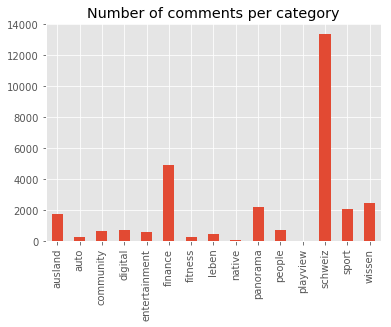

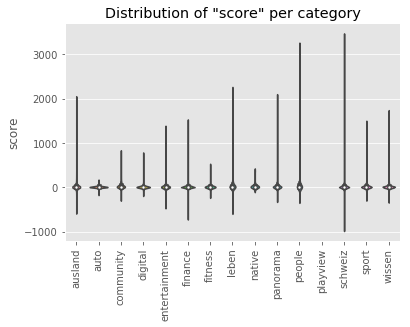

In [14]:
# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# is empty: (= all comments correspond to an article)
print('Number of comments with no "link" from an article:', 
      len(df_merge[pd.isnull(df_merge['link'])]))
# However 1 comment has no article text?
df_merge = df_merge.dropna(axis=0, how='any', subset=['text'])

# Hist - attention: hist now shows num of comments (not articles)
df_merge.groupby(['cat']).size().plot.bar(
    title='Number of comments per category')
plt.xlabel('')
plt.show()

# Distribution
ax = sns.violinplot(x="cat", y="score", data=df_merge)
ax.set_title('Distribution of "score" per category')
plt.xticks(rotation = 90)
plt.xlabel('')
plt.show()

# Part of mobile users, not interesting enough
#parts_mob = df_merge[df_merge['mob'] == True].groupby(['cat']).size() / df_merge.groupby(['cat']).size()
#parts_mob.plot.bar(title='Mobile comments per category')
#plt.show()

# Get order of comments per article
df_merge_sorted = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')

# Add time since the first comment
def get_time_since_first(group):
    first = group.iloc[:1]['time_since_epoch']
    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
    # Remove those very late comments, after x hours
    #group = group[group['time_since_first'] < 36]
    return group

df_merge_sorted = df_merge_sorted.apply(get_time_since_first)

# Summary:
# Score / activity are only possible in certain categories 
#    - the categories with lots of active users

<a id='data-type-optimization'></a>

### Data type optimization

To reduce memory usage. This is technical stuff; contributes nothing to analysis.

In [15]:
# Optimize the data set for memory usage
# Delete these to free memory
try: del df_art; del df_com; del df_merge
except: pass # if already deleted: error

# Type casting
df_merge_sorted['mob'] = df_merge_sorted['mob'].map({
    1: True, 0: False
})

conv = df_merge_sorted.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df_merge_sorted[conv.columns] = conv

conv = df_merge_sorted.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df_merge_sorted[conv.columns] = conv
del conv

# Show memory usage per type
#print(df_merge_sorted.info(memory_usage='deep'))
for dtype in ['float64','int64','object', 'bool', 'category']:
    selected_dtype = df_merge_sorted.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))


Average memory usage for float64 columns: 0.23 MB
Average memory usage for int64 columns: 0.23 MB
Average memory usage for object columns: 21.11 MB
Average memory usage for bool columns: 0.10 MB
Average memory usage for category columns: 0.65 MB


<a id='scatter-plots'></a>

### Scatter plots

We will only plot for a sample, since plotting takes a lot of time otherwise.

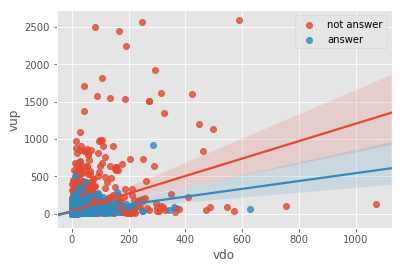

In [16]:
N_SAMPLE = 5000

#sns.pairplot(df_com, x_vars='vup', y_vars='vdo', size=6)
sns.regplot(x='vdo', y='vup', data=df_merge_sorted[df_merge_sorted['is_answer'] == False].sample(N_SAMPLE),
            label='not answer')
sns.regplot(x='vdo', y='vup', data=df_merge_sorted[df_merge_sorted['is_answer'] == True].sample(N_SAMPLE), 
            label='answer')
plt.legend()
plt.show()

# Answers are less up- than downvoted
# Quite some outliers
# Are rows with upvotes of over 1000 real?
# Looked some of them up manually and yes, they have a lot of upvotes (3000+)
# Answers are rather downvoted than upvoted (as can already be seen in the correlation matrix)

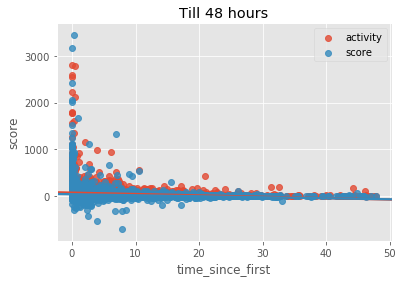

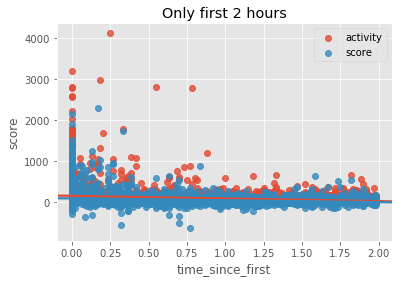

In [17]:
ax = sns.regplot(x='time_since_first', y='activity', label='activity', 
                 data=df_merge_sorted[df_merge_sorted['time_since_first'] < 48].sample(N_SAMPLE))
ax = sns.regplot(x='time_since_first', y='score', label='score', 
                 data=df_merge_sorted[df_merge_sorted['time_since_first'] < 48].sample(N_SAMPLE))
ax.legend()
plt.title('Till 48 hours')
plt.show()

ax = sns.regplot(x='time_since_first', y='activity', label='activity', 
                 data=df_merge_sorted[df_merge_sorted['time_since_first'] < 2].sample(N_SAMPLE))
ax = sns.regplot(x='time_since_first', y='score', label='score',
                 data=df_merge_sorted[df_merge_sorted['time_since_first'] < 2].sample(N_SAMPLE))
ax.legend()
plt.title('Only first 2 hours')
plt.show()


# Summary:
# The time of posting compared to the first comment is not as important as I expected it to be
# Exception: Some early comments make it into "top comments" and get very high scores/activity
# - There are comments where timce_since_first = 1000 hours ???

#sns.regplot(x='vdo', y='vup', data=df_com[df_com['vup'] < 200])
#sns.regplot(x='con_len', y='score', data=df_com)
#plt.show()

<a id='number-of-comments'></a>

### Number of comments during the week

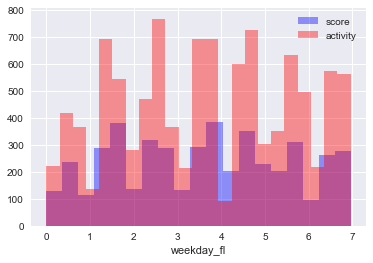

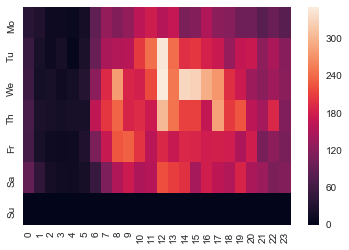

In [18]:
# Plot hist and heat map against weekdays
weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']

sns.set(color_codes=True)
ax = sns.distplot(df_merge_sorted[df_merge_sorted['score']>50]['weekday_fl'], label='score', kde=False, color='blue')
ax = sns.distplot(df_merge_sorted[df_merge_sorted['activity']>50]['weekday_fl'], label='activity', kde=False, color='red')
#ax.set(xticks=range(0, len(weekdays)), xticklabels=weekdays) # This is misleading
ax.legend()
plt.show()

grouped = df_merge_sorted[df_merge_sorted['score']>0].groupby(['weekday', 'hour']).size()
matrix = np.zeros((7, 24))
for d in range(0, 6):
    for h in range(0, 24):
        if d in grouped and h in grouped[d]:
            matrix[d][h] = grouped[d][h]

sns.heatmap(matrix, yticklabels=weekdays)
plt.show()

# 0 = Monday, 7 = Sunday
# Summary:
# The day and time of posting probably plays a big role
# This is probably because on certain days upvoting people are most active
# This does not mean that posting the *same* comment on those times gives you more upvotes

<a id='feature-engineering'></a>

### Feature engineering

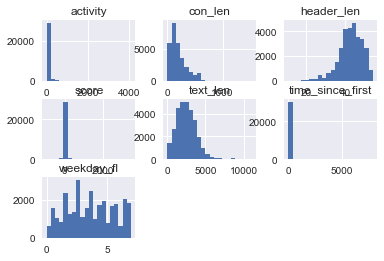

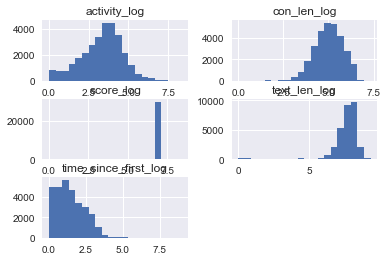

In [19]:
# How are the columns distributed
# Do some feature engineering
# Then look at engineered columns
import math

column = ['weekday_fl', 'con_len', 'header_len', 'text_len', 
          'time_since_first', 'score', 'activity']
df_merge_sorted.hist(column=column, bins=20)

# Reduce skew with log()
column_log = []
for col in ['con_len', 'text_len', 'time_since_first', 'score', 'activity']:
    min_val = df_merge_sorted[col].min()
    df_merge_sorted[col + '_log'] = df_merge_sorted[col].apply(lambda x: math.log(x+1-min_val))
    column_log.append(col + '_log')
a = df_merge_sorted.hist(column=column_log, bins=20)
    
# Log doesn't work that well on "score"
# The problem is that lots of comments have nearly 0 "score"

In [20]:
# Correlations for new columns?
# I removed very weak correlations to "score" and "activity"
cols = ['score', 'activity', 'weekday', 'hour', 'weekday_fl', 'con_len',
       'con_len_log',
       'time_since_first', 'time_since_first_log']
# Get pearson co-efficients
df_merge_sorted[cols].corr()

# Removing skew didn't help with linearity

,score,activity,weekday,hour,weekday_fl,con_len,con_len_log,time_since_first,time_since_first_log
score,1.00,0.84,-0.02,-0.01,-0.02,0.01,0.02,-0.01,-0.18
activity,0.84,1.00,-0.01,-0.01,-0.01,0.02,0.03,-0.02,-0.23
weekday,-0.02,-0.01,1.00,0.01,0.99,-0.01,-0.01,0.01,0.08
hour,-0.01,-0.01,0.01,1.00,0.12,-0.05,-0.06,-0.01,-0.06
weekday_fl,-0.02,-0.01,0.99,0.12,1.00,-0.01,-0.02,0.01,0.07
con_len,0.01,0.02,-0.01,-0.05,-0.01,1.00,0.90,0.00,0.04
con_len_log,0.02,0.03,-0.01,-0.06,-0.02,0.90,1.00,0.01,0.04
time_since_first,-0.01,-0.02,0.01,-0.01,0.01,0.00,0.01,1.00,0.23
time_since_first_log,-0.18,-0.23,0.08,-0.06,0.07,0.04,0.04,0.23,1.00


<a id='prediction-with-linear'></a>

### Prediction with simple linear models
I want to know:
* How to get the best score/consensus (upvotes - downvotes)?
* How to get most activity/agitation (upvotes + downvotes)?
* Which articles go most score resp. activity (sum over all comments)?

...And in the end I want a model predicting my comment text with given day and hour of posting.

In [21]:
# Preprocess and split data into train and test set
from sklearn.model_selection import train_test_split

# Most used words in German
# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für, "
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns, "
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier, "
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

X = df_merge_sorted.drop(['score', 'activity', 'vup', 'vdo'], axis=1)

#def classify(val):
#    if val > 10: return 1
#    return 0
#y = df_merge_sorted['score'].apply(classify)
y = df_merge_sorted['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
# Build a simple intermediate model for text
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
vect = CountVectorizer(preprocessor=no_numbers, min_df=0.1, max_df=0.4, 
                       max_features=100, stop_words=stop_words)

# We used article text here!
# Comment content has a negligible effect (/too few words per comment)(?)
word_model = make_pipeline(vect, Ridge(max_iter=10, alpha=10000, solver='lsqr'))
word_model.fit(X_train['text'], y_train)
y_pred = word_model.predict(X_test['text'])
print("R^2: %1.3f\n" % r2_score(y_test, y_pred))

# Show influence of coefficients(=words)
if True:
    print('Influence of words to "score"\n')
    coeff_by_name = {}
    for i, f in enumerate(word_model.named_steps['countvectorizer'].get_feature_names()):
        coeff_by_name[f] = word_model.named_steps['ridge'].coef_[i]

    coeff_sorted = sorted(coeff_by_name.items(), key=lambda x:x[1], reverse=True)
    NUM_WORDS = 10
    for c in coeff_sorted[0:NUM_WORDS]:
        print("{}\t{}".format(c[0], c[1]))
    print("-----")
    for c in coeff_sorted[-NUM_WORDS:]:
        print("{}\t{}".format(c[0], c[1]))
    
# Grid search to tune parameters
if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {'countvectorizer__max_df': [0.4, 0.5, 0.6],
        'countvectorizer__max_features': [100, 200],
        'ridge__alpha': np.logspace(-1, 3, 5), 'ridge__max_iter': [10, 50, 100], 
                  'ridge__solver': ['svd', 'cholesky', 'lsqr']}
    grid = GridSearchCV(word_models, param_grid, cv=3)
    grid.fit(X_train['con'], y_train)
    
    print("Best estimator:\n{}".format(grid.best_estimator_))

R^2: 0.008

Influence of words to "score"

mann	2.611526504069226
viele	2.539829717456728
frau	2.294213257122128
hätten	2.195645627769251
immer	2.020830063334611
ob	1.850308270625521
dabei	1.4985676425976615
zudem	1.400574237217543
worden	1.2849637083490533
ihrer	1.1833405423571588
-----
ersten	-1.215306125082023
zwei	-1.3912990655061066
erst	-1.4046037735542758
menschen	-1.439595673806609
sollte	-1.461173431922665
gibt	-1.4653763173788406
zwar	-1.4892220775560707
weil	-1.5022502498923962
zürich	-1.5654307013321849
könnte	-1.6784209570627746


In [23]:
# Build a prediction model and test it

# Not all imports needed - trying around
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, Ridge
#from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
#from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list=
        [
            ('statistics', Pipeline([
                ('selector', ItemSelector(
                    key=['weekday', 'hour', 
                         'time_since_first_log', 'con_len_log'])),
                ('scaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=5))
            ]))#,
            
            # Course of dimensionality?
           # ('words', Pipeline([
           #     ('selector', ItemSelector(key='text')),
           #     ('word_model', word_model)
           # ]))
        ],
        
        transformer_weights={
            'statistics': .8#,
            #'words': .2
        }
    )),
    
    # Params not optimized yet
    ('model', Ridge())
    #('model', SVC(kernel='linear', n_jobs=-1))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R^2: %1.3f\n" % r2_score(y_test, y_pred))

'''
# See influence of the polynomial features
print(columns)
features = {}
for i, feature in enumerate(model['union'].named_steps['polynomialfeatures'].get_feature_names()):
    features[feature] = model.named_steps['ridge'].coef_[i]

for name, value in sorted(features.items(), key=lambda x:x[1], reverse=True):
    print("{}\t{}".format(name, value))
'''

# Grid search to tune parameters
if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {'polynomialfeatures__degree': [2, 3, 4, 5],
        'ridge__alpha': np.logspace(-1, 4, 6), 'ridge__max_iter': [10, 50, 100], 'ridge__solver': ['svd', 'cholesky', 'lsqr']}
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    
    print("Best estimator:\n{}".format(grid.best_estimator_))
    #print("Best coefficients:\n{}".format(grid.best_estimator_.named_steps["ridge"].coef_))

R^2: 0.070



<a id='summary'></a>

### Summary so far
Context seems to play a big role in determining up/downvotes, a far bigger role than words used. - This is not surprising, since the number of active readers differs a lot and since words can change their meaning depending on context.  
So maybe the content is not that important, maybe it's more important if it is positive or negative?  
Hypothesis: Earlier comments on an article get more score/activity than later ones; at least there is a weak correlation.

The question is:
* Either my work and resulting model are not good/complex enough enough.
* Or it's not possible to predict "score" from the given data.